Some $\LaTeX$ macros:

$$
\newcommand{\dd}{\mathrm{d}}
\newcommand{\diff}[2]{\frac{\dd #1}{\dd #2}}
$$

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import arviz as az
import corner
import h5py
import pystan
import seaborn as sns
import scipy.special as sp

Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.set_style('ticks')
sns.set_context('paper')
sns.set_palette('colorblind')

Execute the below to set things up for publication-quality plots:

In [3]:
pts_per_inch = 72.0
colwidth = 240.0/pts_per_inch
mpl.rcParams['figure.figsize'] = (colwidth, colwidth)
mpl.rcParams['text.usetex'] = True

Here is a more extensive example that illustrates fitting a the parameters of a Schechter galaxy luminosity function from a flux-limited galaxy survey.

The Luminosity function of galaxies is typically modelled by a Schechter function:
$$
\diff{N}{L} = \frac{\Lambda}{L_*^{1+\alpha} \Gamma\left(1+\alpha\right)} L^\alpha \exp\left[ - \frac{L}{L_*}\right]
$$
with $\alpha > -1$ and $L_*>0$ parameters controlling the shape of the distribution and $\Lambda$ the expected number of galaxies in the survey volume (i.e. the overall normalisation).

Suppose we can measure distances to galaxies perfectly, but that we typically measure fluxes (and therefore luminosities) with $\sigma_L \simeq 5\%$ uncertainty:
$$
p\left( L_\mathrm{obs} \mid L \right) = \frac{1}{\sigma_L L_\mathrm{obs} \sqrt{2\pi}} \exp\left[ - \frac{1}{2} \left(\frac{\log L - \log L_\mathrm{obs}}{\sigma_L} \right)^2\right].
$$

We want to use a flux-limited survey to infer the galaxy luminosity function.  Assume a Euclidean universe, so (in appropriate units)
$$
P_\mathrm{det} \left( L_\mathrm{obs} \right) = \begin{cases}
1 & \frac{L_\mathrm{obs}}{4 \pi z^2} > F_\mathrm{th} \\
0 & \mathrm{otherwise}
\end{cases}
$$
To make things a bit more efficient, we are going to assume that galaxies are distributed uniformly in $z$, rather than volumetrically (this will just reduce the number of low-flux galaxies we need to track in the integral, but dosen't fundamentally change the method).

We will assume that the true values of the parameters are $L_* = 1$, $\alpha = -0.5$, and choose a flux threshold so that we can just observe a $L_*$ galaxy at $z = 1$: $F_\mathrm{th} = \frac{1}{4\pi}$.  The code below draws random glaxies according to these recipes:

In [6]:
def schechter(L, alpha, Lstar):
    return L**alpha*exp(-L/Lstar)/(Lstar**(1+alpha)*sp.gamma(1+alpha))

In [7]:
def draw_redshift(zmax, size=1):
    return zmax*random.uniform(size=size)

In [8]:
def draw_luminosity(alpha, Lstar, size=1):
    xs = (1 - random.uniform(size=size))
    return Lstar*sp.gammaincinv(1+alpha, xs)

In [9]:
def draw_lobs(L, size=1):
    return exp(log(L) + 0.05*randn(size))

In [10]:
def draw_survey(N, alpha, Lstar, Fth, zmax):
    n = random.poisson(N)
    
    Ls = draw_luminosity(alpha, Lstar, size=n)
    zs = draw_redshift(zmax, size=n)
    
    Lobs = draw_lobs(Ls, size=n)
    
    Fobs = Lobs / (4*pi*zs*zs)
        
    sel = Fobs > Fth
    
    z99obs = percentile(zs[sel], 99)
    
    print(f'99th percentile of observed galaxy redshifts is {z99obs:.2f}')
    
    return Lobs[sel], sel.shape[0]-sum(sel)

Here we draw the observations of such a survey, and check that the highest-redshift observed galaxy is well within the maximum redshift that defines our survey volume.

In [11]:
Lambda_true = 100
alpha_true = -0.5
Lstar_true = 1.0
Fth = 1/(4*pi)
zmax = 2
Ls, NNobs = draw_survey(Lambda_true, alpha_true, Lstar_true, Fth, zmax)
print('Found {:d} galaxies and missed {:d} galaxies out to z = {:.1f}'.format(len(Ls), NNobs, zmax))

99th percentile of observed galaxy redshifts is 1.36
Found 29 galaxies and missed 69 galaxies out to z = 2.0


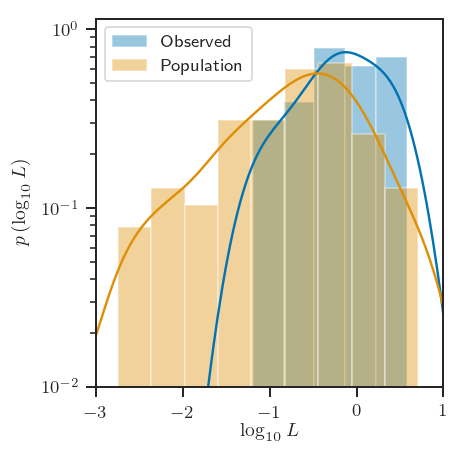

In [10]:
sns.distplot(log10(Ls), label="Observed")
sns.distplot(log10(draw_luminosity(-0.5, 1.0, size=100)), label='Population')
legend(loc='best')
yscale('log')
xlabel(r'$\log_{10} L$')
ylabel(r'$p\left( \log_{10} L\right)$')

axis(xmin=-3, xmax=1, ymin=1e-2)

tight_layout()
savefig('observed-true-luminosity.pdf')

The Stan model is in the file `schechter.stan`; the method is described in the accompanying `Gaussian.ipynb` notebook (we use the mixture-model formulation that proved most efficient in that test).  Note that, unlike for the Gaussian case, there is no analytic form for 
$$
\left\langle P_\mathrm{det} \right\rangle = \int \dd z \, \dd L \, \dd L_\mathrm{obs} \, P_\mathrm{det}\left(  \frac{L_\mathrm{obs}}{4\pi z^2} \right) p\left( L_\mathrm{obs} \mid L, z \right) p\left( L \mid \alpha, L_* \right) p\left(z \right),
$$
so we have to evaluate the fraction of the population that is detected numerically.

In [11]:
model = pystan.StanModel(file='schechter.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_60953421916d63420441761e5497df5d NOW.
/Users/wfarr/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmpe5umlm69/stanfit4anon_model_60953421916d63420441761e5497df5d_4740812685715101588.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


As in `Gaussian.ipynb`, we choose to truncate the number of un-observed systems in the product in the likelihood at a number sufficient to encompass all the support for the number of *physical* non-observed systems; this is the `NNobs_max` parameter below.

In [20]:
fit = model.sampling(
    data = {'Nobs': len(Ls), 'Lobs': Ls, 'NNobs_max': 200, 'Funcert': 0.05, 'zmax': 2, 'Fth': 1.0/(4*pi)},
    iter = 8000,
    thin = 4)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1266551d0>,
      dtype=object)

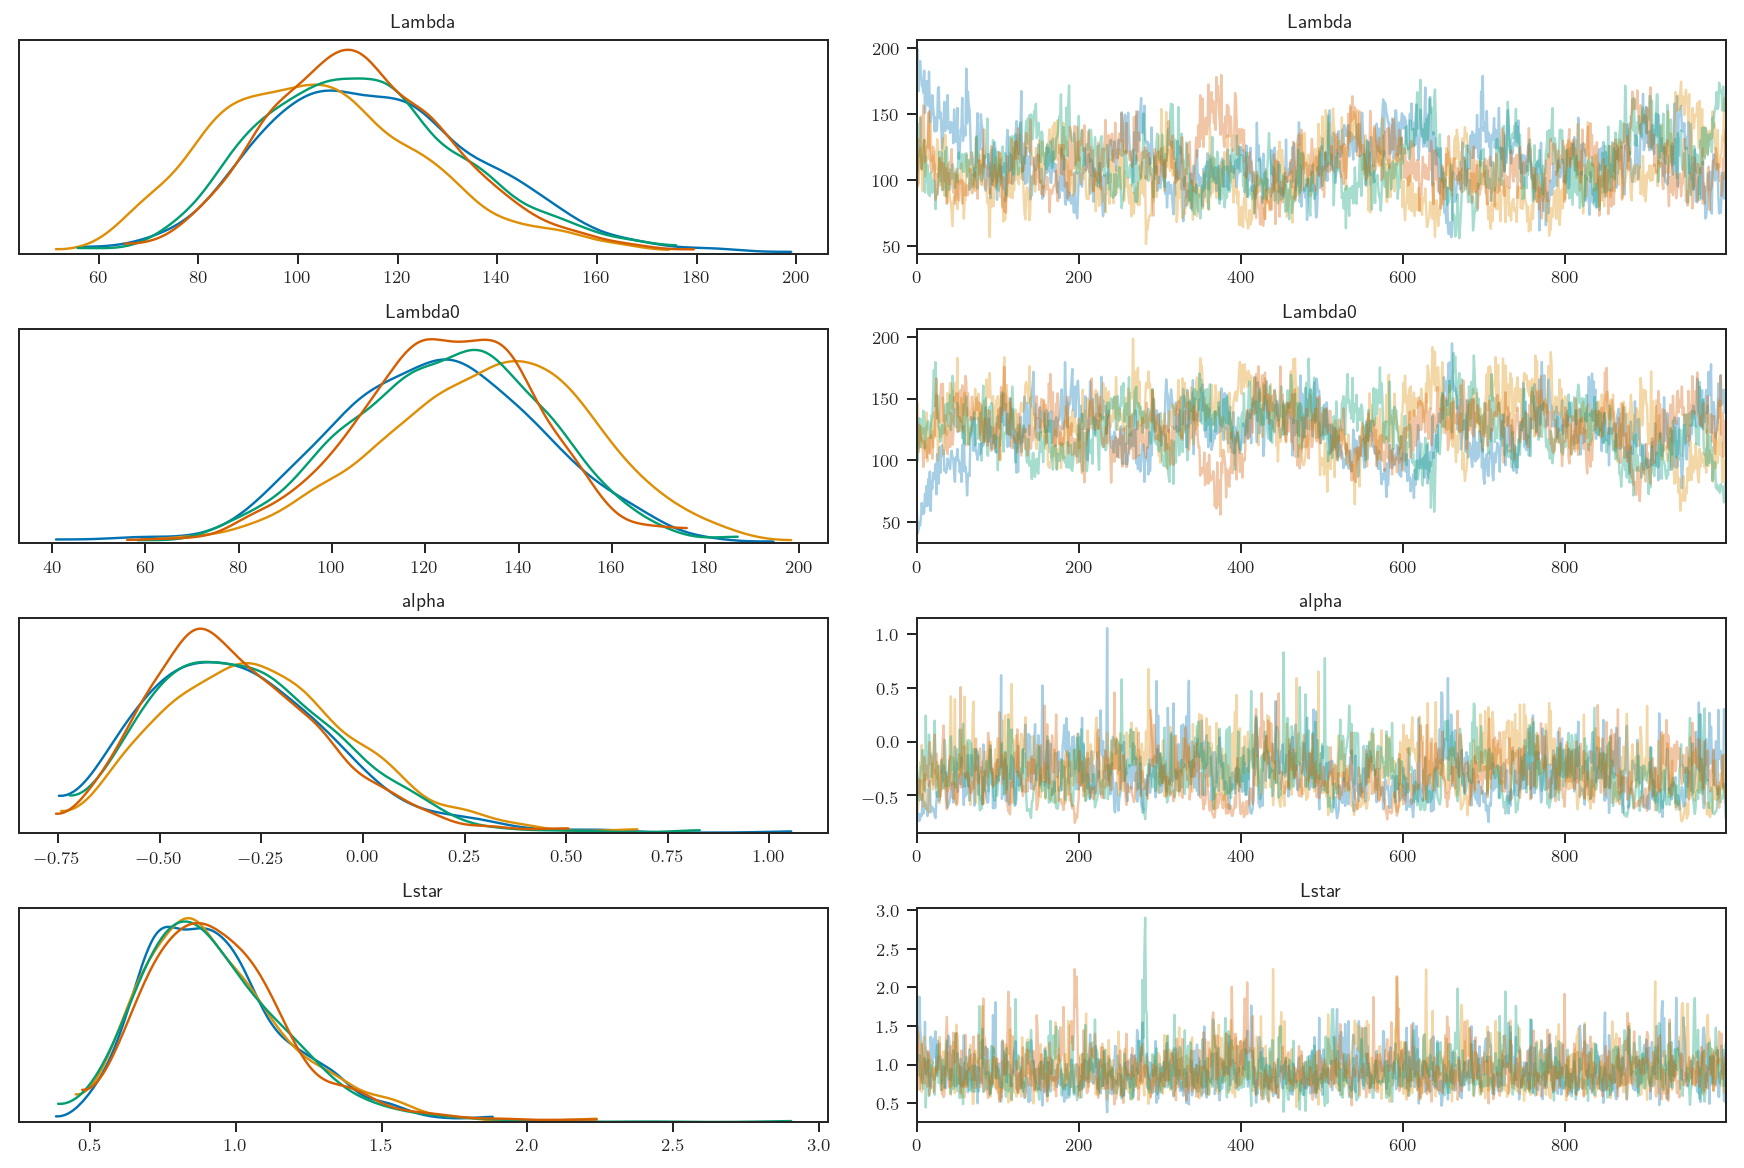

In [21]:
az.plot_trace(fit, var_names=['Lambda', 'Lambda0', 'alpha', 'Lstar'])

In [22]:
print(fit.stansummary(['Lambda', 'Lambda0', 'alpha', 'Lstar']))

Inference for Stan model: anon_model_60953421916d63420441761e5497df5d.
4 chains, each with iter=8000; warmup=4000; thin=4; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Lambda  111.18    1.93  21.37  72.77  96.03 109.74 124.58 156.62    122   1.03
Lambda0 125.93    1.96  21.78  82.78 111.32 126.56 140.66 167.45    123   1.03
alpha    -0.29    0.01   0.22  -0.64  -0.45  -0.31  -0.15   0.21    321   1.01
Lstar     0.94  7.3e-3   0.25   0.56   0.75   0.89   1.07   1.53   1208    1.0

Samples were drawn using NUTS at Mon Mar 25 17:12:04 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


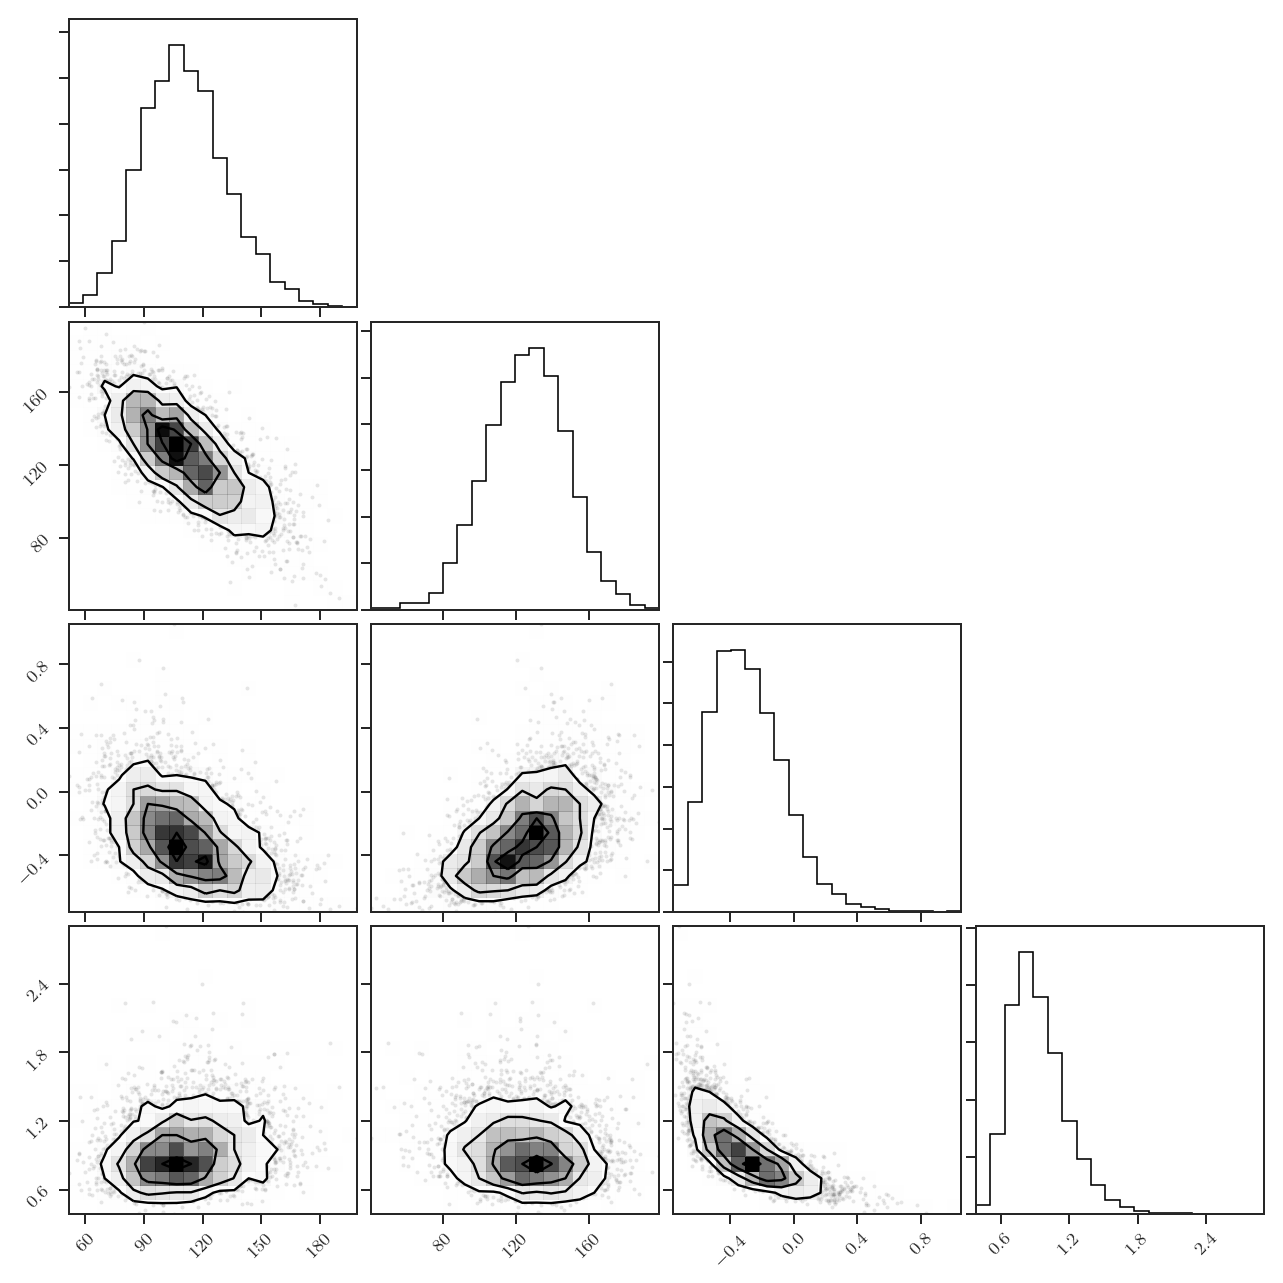

In [24]:
corner.corner(column_stack([fit[k] for k in ['Lambda', 'Lambda0', 'alpha', 'Lstar']]));

In [25]:
chain = fit.extract(permuted=True)

In [28]:
with h5py.File('schechter.h5', 'w') as out:
    d = out.create_group('data')
    p = out.create_group('posterior')
    d.create_dataset('Lobs', data=Ls, compression='gzip', shuffle=True)
    for k in chain.keys():
        p.create_dataset(k, data=chain[k], compression='gzip', shuffle=True)

In [4]:
chain = {}
with h5py.File('schechter.h5', 'r') as f:
    Ls = array(f['data/Lobs'])
    for k in f['posterior'].keys():
        chain[k] = array(f['posterior'][k])

Here come some 1-D marginals:

Text(0, 0.5, '$p\\left( \\Lambda \\right)$')

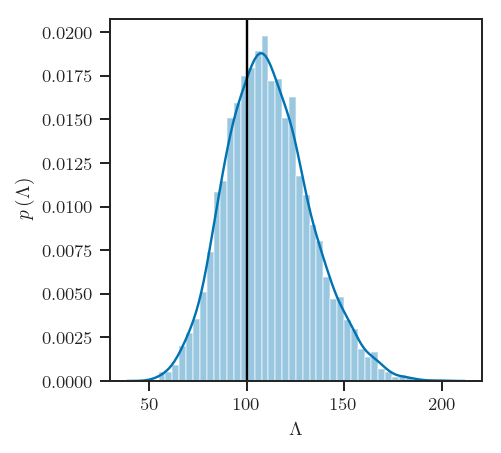

In [12]:
sns.distplot(chain['Lambda'])
axvline(Lambda_true, color='k')
xlabel(r'$\Lambda$')
ylabel(r'$p\left( \Lambda \right)$')

Text(0, 0.5, '$p\\left( \\alpha \\right)$')

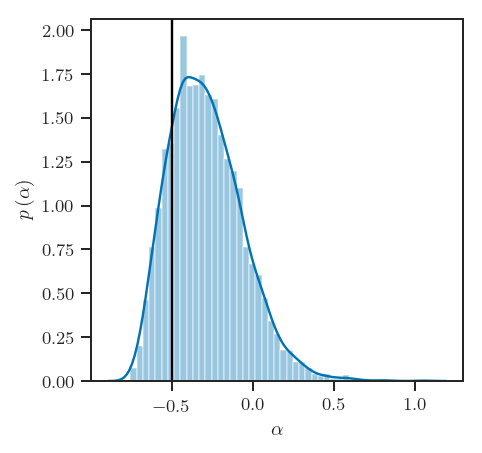

In [13]:
sns.distplot(chain['alpha'])
axvline(alpha_true, color='k')
xlabel(r'$\alpha$')
ylabel(r'$p\left( \alpha \right)$')

Text(0, 0.5, '$p\\left( L_* \\right)$')

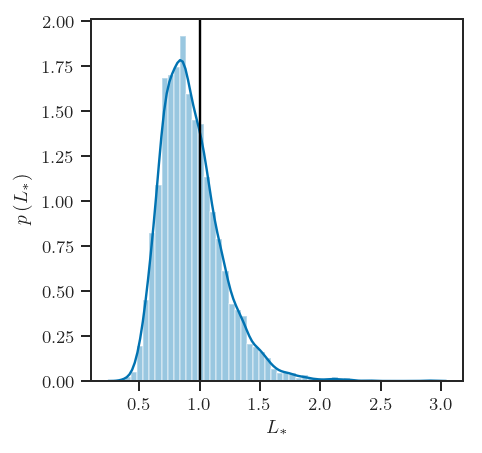

In [14]:
sns.distplot(chain['Lstar'])
axvline(Lstar_true, color='k')
xlabel(r'$L_*$')
ylabel(r'$p\left( L_* \right)$')

And the 2D posterior on the shape parameters for the galaxy luminosity function:

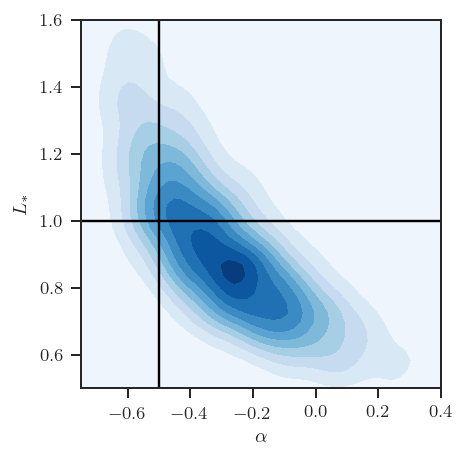

In [15]:
sns.kdeplot(chain['alpha'], chain['Lstar'], shade=True, cmap='Blues')
axvline(alpha_true, color='k')
axhline(Lstar_true, color='k')
xlabel(r'$\alpha$')
ylabel(r'$L_*$')

axis(xmin=-0.75, xmax=0.4, ymin=0.5, ymax=1.6)

tight_layout()
savefig('Lstar-alpha.pdf')

A pretty 1D plot of the inferred galaxy LF (grey) compared to the inverse-detection-efficiency-at-bin-centre-weighted histogram estimator.  Not bad!

/Users/wfarr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Text(0, 0.5, '$\\frac{\\mathrm{d}N}{\\mathrm{d}L}$')

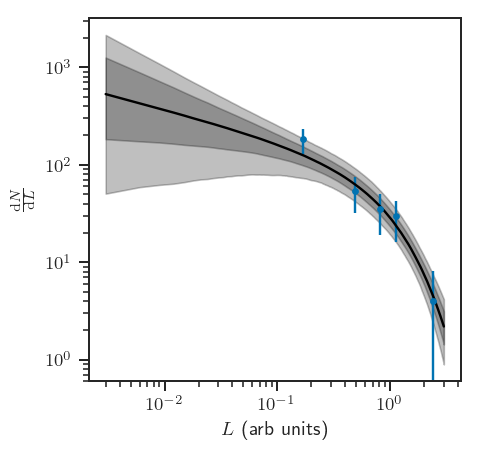

In [16]:
Ls_eval = linspace(0, 3, 1000)[1:]
LFs = []
for L, alpha, Lstar in zip(chain['Lambda'], chain['alpha'], chain['Lstar']):
    LFs.append(L*schechter(Ls_eval, alpha, Lstar))
LFs = array(LFs)
plot(Ls_eval, median(LFs, axis=0), color='k')
fill_between(Ls_eval, percentile(LFs, 84, axis=0), percentile(LFs, 16, axis=0), color='k', alpha=0.25)
fill_between(Ls_eval, percentile(LFs, 97.5, axis=0), percentile(LFs, 2.5, axis=0), color='k', alpha=0.25)

cts, bins = np.histogram(Ls, bins=8)
dndl = cts / diff(bins) / (sqrt(0.5*(bins[1:]+bins[:-1])/(4*pi*Fth))/zmax)

errorbar(0.5*(bins[1:]+bins[:-1]), dndl, dndl/sqrt(cts), fmt='.')

yscale('log')
xscale('log')
xlabel(r'$L$ (arb units)')
ylabel(r'$\frac{\mathrm{d}N}{\mathrm{d}L}$')